# Tissue-specificity of the ascr#10 response

In this notebook, we explore the tissue specificity of the ascr#10 response in *C. elegans*. Please note that most enrichment analyses first count the number of DE genes associated with a specific term, and compare that number with the expected number under a uniform random model--this is called a hypergeometric test. In this notebook, we do NOT perform hypergeometric tests to identify enriched tissues. We take a different approach.

In this notebook, we download the gene expression patterns from Wormbase, and then we test whether genes that are expressed in a given tissue are going UP(down) more often than expected by random chance. We do this using a binomial test. 

The WormBase gene expression-tissue database has been processed in a fairly specific way. First, we removed all non-DE genes at 50 or at 58hrs from the database. Next, we dropped all tissues that did not have at least 5 genes annotated to them. Finally, we removed 'promiscuous genes', genes that are annotated to many (>30) tissues. Originally, the database had 1,535 tissues and after processing we have 264 tissues.

In [1]:
import sys
sys.path.append('../python')
import tissue_utils as utils  # the functions I wrote are here
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import fdrcorrection

from matplotlib import rc
rc('text', usetex=False)
# rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 25, 
      'axes.titlesize': 25, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 18 
mpl.rcParams['ytick.labelsize'] = 18 
mpl.rcParams['legend.fontsize'] = 20 
# load stuff:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)

cols = ['externalgenename', 'log2FoldChange-{0}', 'padj-{0}']
fetch = lambda x: [c.format(x) for c in cols]
rename = lambda x: {'log2FoldChange-{0}'.format(x): 'log2FoldChange', 'padj-{0}'.format(x): 'padj'}

# data wrangling to create a new dataframe that contains the `results` data, but will also include
# the tissue annotations
tmp_list = []
for suffix in ['50', '58']:
    tmp = res[fetch(suffix)].rename(columns=rename(suffix))
    tmp['data'] = suffix
    tmp = tmp[tmp.padj < 0.05]
    print(suffix, tmp.shape)
    tmp_list += [tmp]

annotated_data = pd.concat(tmp_list)
cat_type = pd.CategoricalDtype(categories=['50', '58'], ordered=True)
annotated_data.data = annotated_data.data.astype(cat_type)

# load tissue dictionary:
tissues = utils.load_tissues(res.index, 5, 30)

50 (1663, 4)
58 (3622, 4)
tissues originally: 2359
tissues afterwards: 846


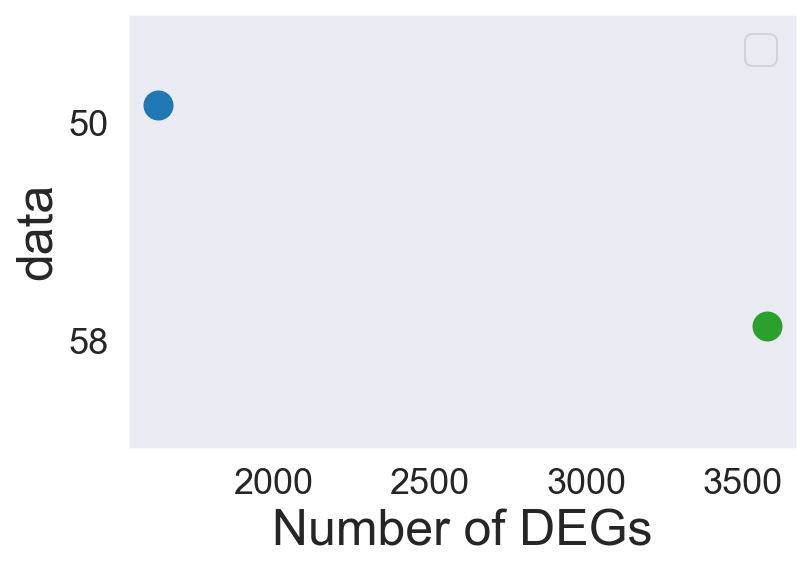

In [2]:
counts = annotated_data[annotated_data.padj < 0.05].groupby('data').externalgenename.count().rename('DEG count').reset_index()
sns.stripplot(y='data', x='DEG count', hue='data', data=counts,
              s=15, palette={'50': 'tab:blue', '58': 'tab:green', 'tph1-50': 'blue', 'tph1-58': 'green', 'pqm1': 'tab:purple'})
plt.legend([])
plt.xlabel('Number of DEGs')
plt.savefig('../figs/DEG_number.svg', bbox_inches='tight')

## Testing the tissues.

In the cell above, we loaded our data, and we also loaded our gene expression pattern database into a variable called `tissues`. Here, we perform a binomial test on each of the tissue programs.

In [3]:
# perform a binomial test for change in direction:
alpha = 0.05
data = utils.test_tissue_direction(res[(res['padj-58'] < 0.05) & (res['Sign-WT'] == 'Same')], tissues)
data_50 = utils.test_tissue_direction(res[(res['padj-50'] < 0.05) & (res['Sign-WT'] == 'Same')], tissues, col='log2FoldChange-50')

data = pd.concat([data, data_50], keys=['58hrs', '50hrs']
                ).reset_index().rename(
                columns={'level_0': 'data'}
                ).drop('level_1', axis=1)

data = utils.fdr_correct(data)
data.sort_values('fdr', inplace=True)

data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)
data['MeanFracPos'] = data.groupby(['tissue', 'data']).FracPos.transform(np.mean)

# keep only significant results:
keep = data.groupby('tissue').sig.sum()
data = data[data.tissue.isin(keep[keep > 0].index)]

m = 'There were {0} tissues that changed more in one direction than expected by random chance in dataset {1}'
for n, g in data.groupby('data'):
    print(m.format(len(g), n))
    
data.head()

There were 41 tissues that changed more in one direction than expected by random chance in dataset 50hrs
There were 44 tissues that changed more in one direction than expected by random chance in dataset 58hrs


,data,tissue,pval,FracPos,FracPosExpected,fdr,neglogq,sig,MeanFracPos
0,58hrs,germ line,2.896386e-23,0.951613,0.646437,7.125109e-21,20.147208,True,0.951613
1,58hrs,Cell,4.057242e-11,0.936842,0.646437,4.990408e-09,8.301864,True,0.936842
2,58hrs,nervous system,6.766480e-11,0.836066,0.646437,5.548514e-09,8.255823,True,0.836066
3,58hrs,body wall musculature,1.081277e-10,0.817568,0.646437,6.649853e-09,8.177188,True,0.817568
4,58hrs,pharynx,9.193526e-10,0.797688,0.646437,4.523215e-08,7.344553,True,0.797688


Next, let's remove uninformative terms like `cell`, `tail` or `head`. I will also remove highly similar terms to prevent too much redundancy. For completeness, I've made sure to print all tissues that I will remove:

In [4]:
remove = ['Cell', 'tail', 'head', 'male gonad', 'gonad', ]  # so broad. why ever have these terms...
remove = utils.similarity_trimming(data.tissue.unique(), tissues, remove)
print('The following list of tissues will be removed from the plot', list(set(remove)))

The following list of tissues will be removed from the plot ['mu-int-R', 'vulval muscle', 'male gonad', 'hermaphrodite gonad', 'tail', 'nervous system', 'ventral cord neuron', 'P0', 'tail neuron', 'mu-int-L', 'anal depressor muscle', 'body region', 'Z2', 'gonad', 'anterior distal tip cell', 'Cell', 'head', 'Psub2']


Let's plot the results:

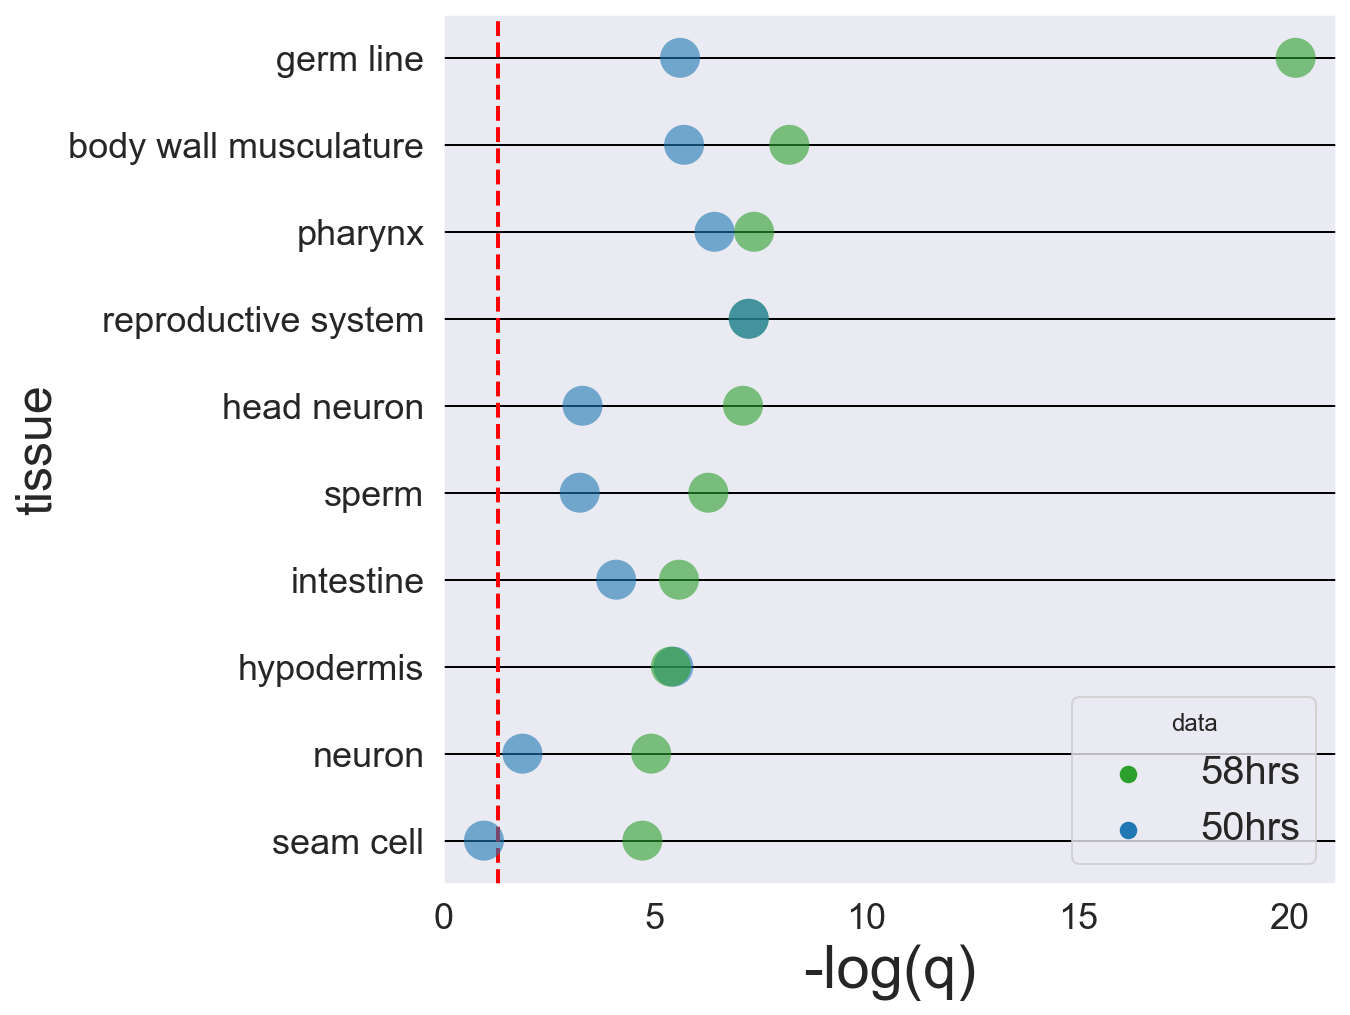

In [5]:
to_plot = data[(~data.tissue.isin(remove)) & (data.sig == True)].head(15)  # get top 15 hits or so
to_plot = data[(data.tissue.isin(to_plot.tissue))]  # only use the top 10-15 tissues for this plot

tissues_plotted = to_plot.tissue.unique()
fig, ax = utils.pretty_GSEA_plots(to_plot, sig_level=alpha, size=20, alpha=0.6)
ax.yaxis.grid(color='black', linewidth=1)
ax.set_xlabel('-log(q)', fontsize=30)
plt.savefig('../figs/tissue_GSEA.svg', bbox_inches='tight', transparent=False)

## Volcano Plot

Here is the volcano plot that was reproduced in the paper:

/Users/davidangeles/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


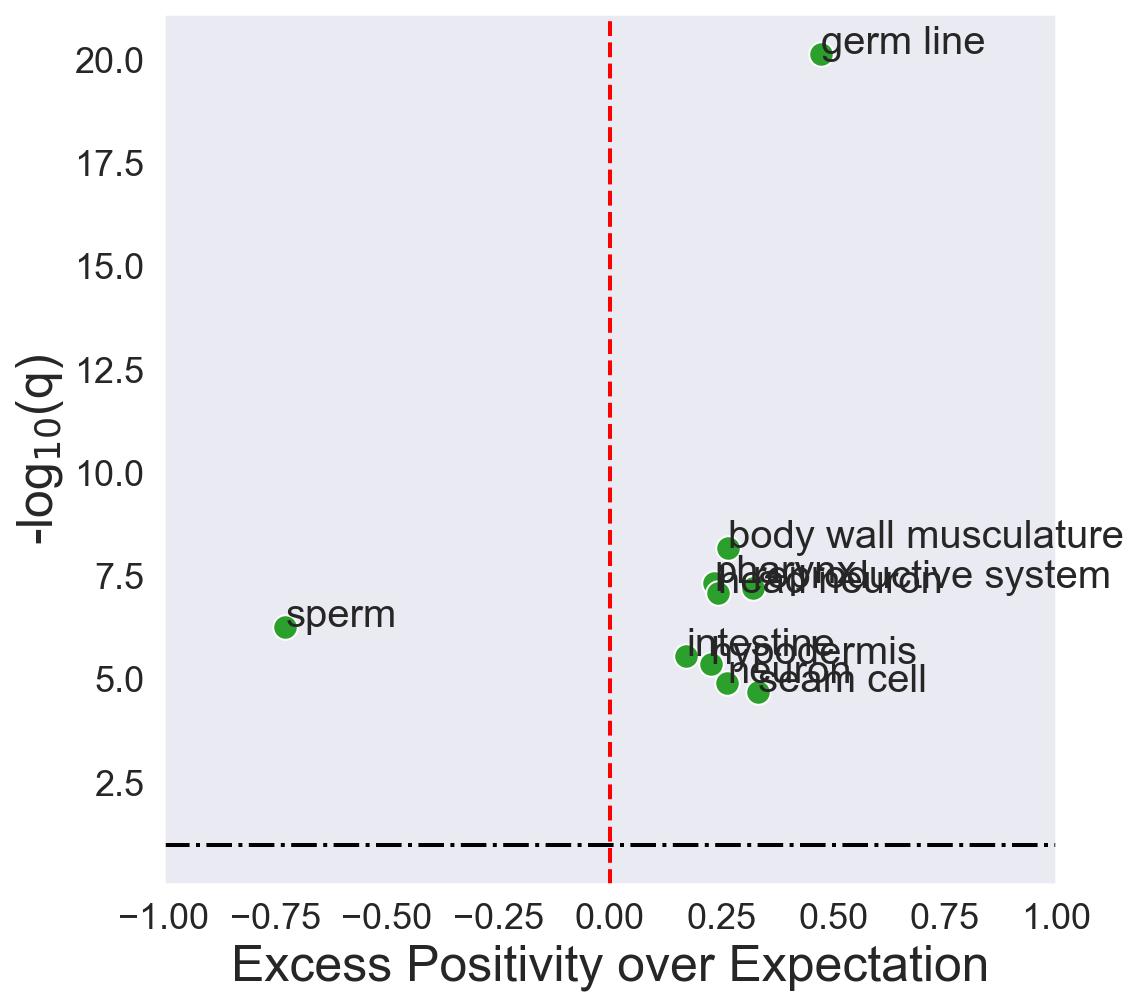

In [6]:
to_plot['Excess'] = (to_plot.FracPos - to_plot.FracPosExpected) / to_plot.FracPosExpected 

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x='Excess', y='neglogq', data=to_plot[to_plot.data  == '58hrs'], s=150, color='tab:green', ax=ax)

for tissue, df in to_plot[to_plot.data == '58hrs'].groupby('tissue'):
    plt.annotate(tissue, (df.Excess.unique()[0], df.neglogq.unique()[0]),
                 fontsize=20)
#     print(df.head())

# plt.axvline(to_plot.FracPosExpected.unique()[0], color='red', ls='--', label='Expected % of Genes UP')
plt.axhline(1, color='black', ls='-.', label='Expected % of Genes UP')
plt.axvline(0, color='red', ls='--')
plt.xlim(-1, 1)
plt.xlabel('Excess Positivity over Expectation')
plt.ylabel('-log$_{10}$(q)')

plt.savefig('../figs/tissue_volcano.svg', bbox_inches='tight', transparent=False)

# Directional analysis of gene subsets.

In the next section, we pull out all the vitellogenin genes, the major sperm protein genes and all ribosome small / large subunit genes, and we plot their measured log Fold Change at 50 and 58 hours. 

In [7]:
res = pd.read_csv('../data/master_table.tsv', sep='\t', index_col=0)
res = res.dropna(subset=['log2FoldChange-50', 'log2FoldChange-58'])
tissues = utils.load_tissues(res.index, 5, 30)
annotated_data = res.join(tissues.set_index('wbid')).dropna(subset=['tissue'])

tissues originally: 2359
tissues afterwards: 846


['vit-1' 'vit-2' 'vit-3' 'vit-4' 'vit-5' 'vit-6']
['msp-3' 'msp-19' 'msp-31' 'msp-33' 'msp-36' 'msp-38' 'msp-40' 'msp-45'
 'msp-49' 'msp-50' 'msp-51' 'msp-53' 'msp-55' 'msp-56' 'msp-57' 'msp-59'
 'msp-64' 'msp-65' 'msp-76' 'msp-77' 'msp-78' 'msp-81' 'msp-113' 'msp-142'
 'msp-152']
['rpl-1' 'rpl-2' 'rpl-3' 'rpl-4' 'rpl-5' 'rpl-6' 'rpl-7' 'rpl-7A' 'rpl-9'
 'rpl-10' 'rpl-11.1' 'rpl-11.2' 'rpl-12' 'rpl-13' 'rpl-14' 'rpl-15'
 'rpl-16' 'rpl-17' 'rpl-18' 'rpl-19' 'rpl-20' 'rpl-21' 'rpl-22' 'rpl-23'
 'rpl-24.1' 'rpl-24.2' 'rpl-25.1' 'rpl-25.2' 'rpl-26' 'rpl-27' 'rpl-28'
 'rpl-29' 'rpl-30' 'rpl-31' 'rpl-32' 'rpl-33' 'rpl-34' 'rpl-35' 'rpl-36'
 'rpl-37' 'rpl-38' 'rpl-39' 'rpl-41' 'rpl-43' 'rps-0' 'rps-1' 'rps-2'
 'rps-3' 'rps-4' 'rps-5' 'rps-6' 'rps-7' 'rps-8' 'rps-9' 'rps-10' 'rps-11'
 'rps-12' 'rps-13' 'rps-14' 'rps-15' 'rps-16' 'rps-17' 'rps-18' 'rps-19'
 'rps-20' 'rps-21' 'rps-22' 'rps-23' 'rps-24' 'rps-25' 'rps-26' 'rps-27'
 'rps-28' 'rps-29' 'rps-30']


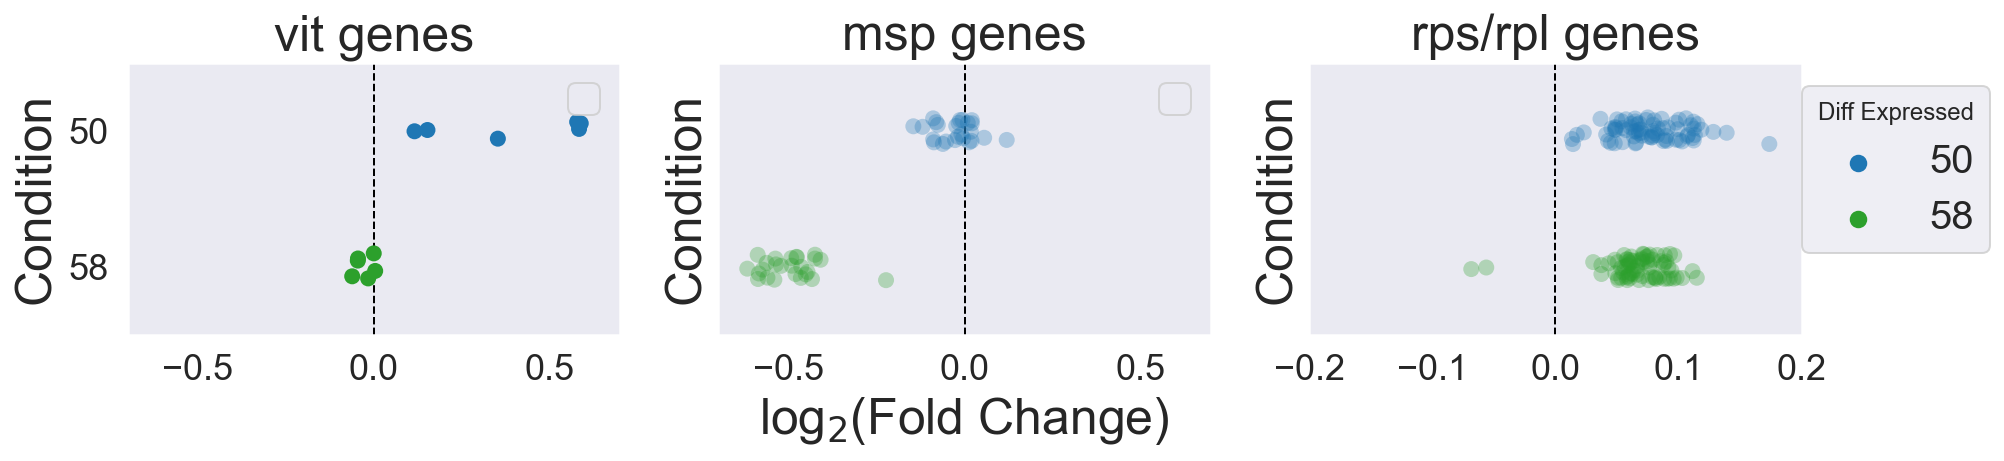

In [8]:
def plot_gene_fam(res, title, ax=ax):
    """Plot genes that start with the suffix `title` in a stripplot"""
    selected = (res.Gene.fillna('').str.contains(title)) &\
               (res.Gene.str.split('-', expand=True)[0].astype(str).apply(lambda x: len(x)) == 3)

    colors = {'58': 'tab:green', '50': 'tab:blue', 'pqm1': 'tab:purple',
              'tph1-50': 'blue', 'tph1-58': 'green'}
    
    log_cols = ['Gene'] + [c for c in res.columns if ('log2' in c)]
    pval_cols = ['Gene'] + [c for c in res.columns if ('padj' in c)]

    tidy = res[selected][log_cols].melt(id_vars='Gene', var_name='Condition', value_name='logFoldChange')
    tidy_qvals = res[selected][pval_cols].melt(id_vars='Gene', var_name='Condition', value_name='qval')

    tidy.Condition = tidy.Condition.str.replace('log2FoldChange-', '')
    tidy_qvals.Condition = tidy_qvals.Condition.str.replace('padj-', '')

    tidy = tidy.join(tidy_qvals.set_index(['Gene', 'Condition']), on=['Gene', 'Condition'])
    tidy['Sig'] = tidy.qval < 0.1
    
    print(tidy.Gene.unique())
    if len(tidy) > 30:
        alpha = .3
    else:
        alpha= 1

    sns.stripplot(y='Condition', x='logFoldChange', hue='Condition', alpha=alpha,
                  s=8, data=tidy, orient='h', palette=colors, ax=ax)
    ax.axvline(0, color='black', ls='--', lw=1)
    ax.legend(loc=(1, .3), title='Diff Expressed')
    ax.set_title(title + ' genes')

def three_panel_plot(res):
    """A function to plot the three desired panels"""
    fig, ax = plt.subplots(ncols=3, sharey=True, sharex=False, figsize=(15, 2.5))
    plot_gene_fam(res, title='vit', ax=ax[0])
    plot_gene_fam(res, title='msp', ax=ax[1])
    plot_gene_fam(res, title='^rp[sl]', ax=ax[2])

    ax[2].set_title('rps/rpl genes')

    ax[0].legend([])
    ax[1].legend([])

    ax[0].set_xlabel('')
    ax[2].set_xlabel('')

    ax[1].set_xlabel('log$_2$(Fold Change)')

    ax[0].set_xlim(-.7, .7)
    ax[1].set_xlim(-.7, .7)
    ax[2].set_xlim(-.2, .2)
    return fig, ax


fig, ax = three_panel_plot(res)
plt.savefig('../figs/gene_programs.svg', bbox_inches='tight', transparent=False)